In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import datetime
import seaborn as sns

pd.set_option("display.max_columns", None)

* read DM and non-DM datasets

In [ ]:
data = pd.read_json('/content/drive/MyDrive/Accountstory/data/combined_dataset_20210930.json')

# clean data

In [ ]:
data.columns

* kick out (presumably) useless features

In [ ]:
useless_features = [ 'full_name', 'middle_initial', 'middle_name', 'last_name'
                    , 'birth_date', 'linkedin_url',
       'linkedin_username', 'linkedin_id', 'facebook_url', 'facebook_username',
       'facebook_id', 'twitter_url', 'twitter_username', 'github_url',
       'github_username', 'work_email', 'personal_emails', 'mobile_phone',
       'industry', 'job_company_id', 'job_company_name',
       'job_company_website', 'job_company_size', 'job_company_founded',
       'job_company_industry', 'job_company_linkedin_url',
       'job_company_linkedin_id', 'job_company_facebook_url',
       'job_company_twitter_url', 'job_company_location_name',
       'job_company_location_locality', 'job_company_location_metro',
       'job_company_location_region', 'job_company_location_geo',
       'job_company_location_street_address',
       'job_company_location_address_line_2',
       'job_company_location_postal_code', 'job_company_location_country',
       'job_company_location_continent', 'job_last_updated',
       'location_name', 'location_locality', 'location_metro',
       'location_region', 'location_country', 'location_continent',
       'location_street_address', 'location_address_line_2',
       'location_postal_code', 'location_geo', 'location_last_updated',
       'phone_numbers', 'emails', 'interests', 'location_names',
       'regions', 'countries', 'street_addresses',
       'profiles', 'version_status'
                   ]

In [ ]:
data.drop(useless_features, axis=1, inplace=True)
print('%s rows, %s features' % data.shape)
data.head()

In [ ]:
data['education'].iloc[0]

[{'degrees': [],
  'end_date': None,
  'gpa': None,
  'majors': [],
  'minors': [],
  'school': {'domain': None,
   'facebook_url': None,
   'id': None,
   'linkedin_id': None,
   'linkedin_url': None,
   'location': None,
   'name': 'udesc - universidade do estado de santa catarina',
   'twitter_url': None,
   'type': 'post-secondary institution',
   'website': None},
  'start_date': None},
 {'degrees': ['bachelors'],
  'end_date': '2015',
  'gpa': None,
  'majors': ['industrial engineering'],
  'minors': [],
  'school': {'domain': 'udesc.br',
   'facebook_url': 'facebook.com/udesc',
   'id': '87X1yOBseotKglAxj2pF2w_0',
   'linkedin_id': '10625',
   'linkedin_url': 'linkedin.com/school/universidade-do-estado-de-santa-catarina',
   'location': {'continent': 'south america',
    'country': 'brazil',
    'locality': 'florianópolis',
    'name': 'florianópolis, santa catarina, brazil',
    'region': 'santa catarina'},
   'name': 'universidade do estado de santa catarina',
   'twitter_url'

# fearture engeneering

* infer ancestry and gender from first (given) name
* scrape name list from namecensus.com

In [ ]:
URL = 'https://namecensus.com/top-first-names/top-first-names-since-1950.html'
page = requests.get(URL)
print(page)

soup = BeautifulSoup(page.content, "html.parser")

<Response [200]>


In [ ]:
us_name_list = {}
html_table = soup.find_all("td")[5:]
for idx in range(len(html_table)):
    if (idx) % 5 == 1:
        us_name_list[html_table[idx].text.lower()] = html_table[idx+1].text

In [ ]:
data['us_name'] = 0
for idx, name in enumerate(data['first_name']):
    if name in us_name_list.keys():
        data.at[idx, 'us_name'] = 1
        
data.drop('first_name', axis=1, inplace=True) # drop 'name' column

# gender string to integer
data.loc[(data['gender'] == 'male'), 'gender'] = 1
data.loc[(data['gender'] == 'female'), 'gender'] = -1
data.loc[(data['gender'] == 'None'), 'gender'] = 0
data.loc[(data['gender'] == None), 'gender'] = 0

In [ ]:
data

* skills, experience and education are nested lists. Let's make it flat.

* education: important features: school name, degrees, majors

* rank colleges and assign **uni_rank** to every person

In [ ]:
uni_rank = pd.read_csv('/content/drive/MyDrive/Accountstory/data/uni_rank.csv', sep='\t')[['World Rank', 'Institution']].to_dict()['Institution']

In [ ]:
def string_replace(origignal_string):
    origignal_string = origignal_string.lower()
    str_lst = ['\n', ',', '\xa0', 'university', 'of california', 'of ', '-', '–', ' ']
    
    for string in str_lst:
        origignal_string = origignal_string.replace(string, '')
    
    origignal_string = re.sub(r"\([^()]*\)", "", origignal_string) # remove parantheses
    origignal_string = re.sub(r"^\s+", "", origignal_string) # remove needing space
    origignal_string = re.sub(r"\s+$", "", origignal_string) # remove trailing space
    return origignal_string

uni_rank = {string_replace(y):x for x,y in uni_rank.items()}
uni_rank['mit'] = uni_rank['massachusettsinstitutetechnology']
uni_rank['caltec'] = uni_rank['californiainstitutetechnology']

In [ ]:
person_uni_rank = np.zeros(len(data))
n = len(uni_rank)
for person in range(len(data)):
    for school in data['education'][person]:
        try:
            if string_replace(school['school']['name']) in uni_rank:
                person_uni_rank[person] +=  n - uni_rank[string_replace(school['school']['name'])]
        
        except:
            pass

In [ ]:
data['uni_rank'] = person_uni_rank.astype(int)

* degrees: make a score. 1 point for each degree

In [ ]:
degree_score = np.zeros(len(data))
for person in range(len(data)):
    for school in data['education'][person]:
        if school['degrees']:
            degree_score[person] += 1

In [ ]:
data['degree_score'] = degree_score

* major (one-hot)

In [ ]:
# one-hot
for person in range(len(data)):
    for school in data['education'][person]:
        #print(school['majors'])
        for major in school['majors']:
            maj = 'edu_' + major
            if maj not in data:
                data[maj] = 0
            data[maj][person] = 1

* drop **education** column

In [ ]:
data.drop('education', axis=1, inplace=True)

* calculate age

In [ ]:
data['age'] = 2021 - np.array(data['birth_year'])

In [ ]:
data.drop('birth_year', axis=1, inplace=True)

* drop **job_title** (it is encoded in **job_title_role**, **job_title_sub_role** and **job_title_levels**)

In [ ]:
data.drop('job_title', axis=1, inplace=True)

* calculate months of service

In [ ]:
mos = []
for d in np.array(data['job_start_date']):
    try:
        date = datetime.datetime.strptime(d, '%Y-%m')
        mos.append(12 * (datetime.datetime.now().year - date.year) + (datetime.datetime.now().month - date.month))
        
    except:
        mos.append(None)

In [ ]:
data['month_of_service'] = mos

In [ ]:
data.drop('job_start_date', axis=1, inplace=True)

In [ ]:
data.head()

* **job_title_levels** (one-hot)

In [ ]:
unique_attributes = []
for elem_lst in data['job_title_levels']:
    for elem in elem_lst:
        string = 'level_' + elem
        if string not in unique_attributes:
            unique_attributes.append(string)
            data['level_' + elem] = 0
unique_attributes

['level_manager',
 'level_director',
 'level_senior',
 'level_vp',
 'level_owner',
 'level_cxo',
 'level_partner',
 'level_entry',
 'level_training']

In [ ]:
for idx, elem_lst in enumerate(data['job_title_levels']):
    for elem in elem_lst:
        data['level_' + elem][idx] = 1

In [ ]:
data.drop('job_title_levels', axis=1, inplace=True)

* no good idea how to handle **skills** at the moment. It's just too many per person. Quick and dirty: just calculate number of skills

In [ ]:
data['skills_count'] = None
for idx, skills in enumerate(data['skills']):
    data['skills_count'][idx] = len(skills)

In [ ]:
data.drop('skills', axis=1, inplace=True)

* there are entries with 0 skills. I will assign the median skill_count to those people

In [ ]:
median = np.median(data['skills_count'])
for idx, skill_cnt in enumerate(data['skills_count']):
    if skill_cnt == 0:
        data['skills_count'][idx] = int(median)

* for **experience** just count the number of different companies.
* add feature that indicates if person worked at a global 10001+ employee company

In [ ]:
data['company_count'] = 0
data['company_global'] = 0
for idx, elem_lst in enumerate(data['experience']):
    data['company_count'][idx] = len(elem_lst)
    for elem in elem_lst:
        try:
            if elem['company']['size'] == '10001+':
                data['company_global'][idx] = 1
        except:
            pass

In [ ]:
data.drop('experience', axis=1, inplace=True)

* here the decision tree model splits at **job_title_sub_role** which makes no sence because there is no order in these categories

* I need to one-hot encode that category

In [ ]:
data = data.join(pd.get_dummies(data['job_title_role'],prefix='role', prefix_sep='_'))
data = data.drop('job_title_role', axis=1)

data = data.join(pd.get_dummies(data['job_title_sub_role'], prefix='sub_role', prefix_sep='_'))
data = data.drop('job_title_sub_role', axis=1)

In [ ]:
data.shape # (rows, features)

In [ ]:
data

* correlation map

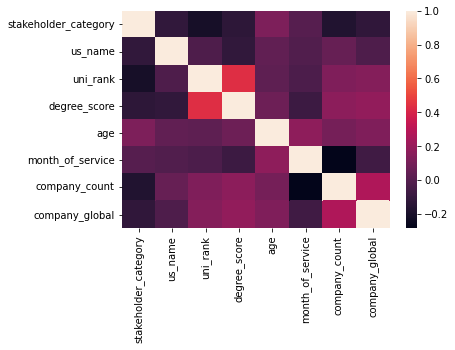

In [ ]:
corr = data[['gender','stakeholder_category','us_name','uni_rank','degree_score','age','month_of_service','skills_count','company_count','company_global']].corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

* fill NaN

In [ ]:
# gender: NaN -> 0
data['gender'].fillna(0,inplace=True)

# age: NaN -> avergage
ave_age = int(np.mean(data.age))
data['age'].fillna(ave_age,inplace=True)

# months of service: NaN -> avergage
ave_mos = int(np.mean(data.month_of_service))
data['month_of_service'].fillna(ave_mos,inplace=True)

*  the DM dataset had a lot of NaN in age.

* drop the age column

In [ ]:
data = data.drop('age', axis=1)

* export training dataset

In [ ]:
data.to_json('/content/drive/MyDrive/Accountstory/data/TRAINING_dataset_20210930.json')